# Chapter 4: Finding Top Words for Data Analysis

Dear user, now that the data collected is clean, \
we can split the chunks of text into words to find the most mentioned words.

### REQUIREMENTS

For this notebook, you need to have:
- 5 x Pickle files of Scraped data from Online sources (from Chap2.ipynb)

### TO DO SECTION

In [1]:
'''
Dear user, enter your Product here!
'''

product = "Scoot 787"

In [2]:
'''
Dear user, enter your 5 Online sources and \
directories to the 5 Pickle files of Scraped data here!
'''
sources = ['youtube', 'reddit', 'article', 'brochure', 'textbook']       # In sequence from source 1 to source 5

source1_dir = f"support/{product}/{sources[0]}/comment_list.pkl"
source2_dir = f"support/{product}/{sources[1]}/comment_list.pkl"
source3_dir = f"support/{product}/{sources[2]}/{sources[2]}.pkl"
source4_dir = f"support/{product}/{sources[3]}/{sources[3]}.pkl"
source5_dir = f"support/{product}/{sources[4]}/{sources[4]}.pkl"

In [3]:
'''
Dear user, please replace [Ctrl-F] the variable names and following variable names with the 5 Online sources used (in the same format)!
'''
youtube_comment_list = None
all_youtube_comments = None

reddit_comment_list = None
all_reddit_comments = None

article = None

brochure = None

textbook = None

### RUN AS INTENDED (DO NOT CHANGE ANYTHING.)

##### Set Up

In [4]:
""" Initialise and Establish Dataset """
import pandas as pd

search_terms = product

youtube_comment_list = pd.read_pickle(source1_dir)

reddit_comment_list = pd.read_pickle(source2_dir)

article = pd.read_pickle(source3_dir)

brochure = pd.read_pickle(source4_dir)

textbook = pd.read_pickle(source5_dir)

## Splitting Text Chunk into Words

In [5]:
""" Join all Comments into a corpus (only for Comments)"""
def combine_text(list_of_text):                     # define combine_text to take (list_of_text)
    combined_text = ' '.join(list_of_text)          # do this
    return combined_text                            # and give combined_text back

In [6]:
print("Joining youtube comments...")
all_youtube_comments = combine_text(youtube_comment_list)
print(all_youtube_comments)
print()
print("Joining reddit comments...")
all_reddit_comments = combine_text(reddit_comment_list)
print(all_reddit_comments)

Joining youtube comments...
i went in this airline the service was not good i almost slept the whole flight without eating and entertainment but i guess every airline does not have tv is so i just decided airlines with tv is is not always the best i learned my lesson the non tv is are the same as tv is for a good 787 is the first scoot flight i had i think they should have these planes to bring back 747 757 a340 a380 717 727 737 232 i love the idea of silent economy which is just economy plus with no children screaming  thanks for your video one question which kind of plug your seat had was that compatible with a c type thanks  i will be your guide on how to survive scoot long haul flights 1 bring a power bank fully charged 2 bring some snacks with you onboard 3 bring a gaming handheld to play some games to kill some time 4 bring your own amenities like eye masks earplugs toothbrushes and toothpaste one hour in economy flight for me 4 hours it can be very uncomfortable like flying indi

In [7]:
""" Remove stopwords and Split """
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def proper_split(text):
    all_text = " ".join(word for word in text.split() if word not in stopwords)
    print(all_text)
    return all_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
print("Split youtube comments:")
all_youtube_comments = proper_split(all_youtube_comments)
print()
print("Split reddit comments:")
all_reddit_comments = proper_split(all_reddit_comments)
print()
print("Split article:")
article = proper_split(article)
print()
print("Split brochure:")
brochure = proper_split(brochure)
print()
print("Split textbook:")
textbook = proper_split(textbook)

Split youtube comments:
went airline service good almost slept whole flight without eating entertainment guess every airline tv decided airlines tv always best learned lesson non tv tv good 787 first scoot flight think planes bring back 747 757 a340 a380 717 727 737 232 love idea silent economy economy plus children screaming thanks video one question kind plug seat compatible c type thanks guide survive scoot long haul flights 1 bring power bank fully charged 2 bring snacks onboard 3 bring gaming handheld play games kill time 4 bring amenities like eye masks earplugs toothbrushes toothpaste one hour economy flight 4 hours uncomfortable like flying indigo india singapore flights 5hrs flying scoot philippines year got self 3 4 hours paid dollar160 1 hour flight airline low quality low coster ah 05 40 famous vomid turn german kotzkurve nice 7 15 actually bring food drinks scoot happy travels scoot even use ife flight enjoy sound take landing maybe eat sleep would issue took airlines sing

## Graph Visualisation of Top Words

In [9]:
""" Find and Plot top words """
import pickle
from collections import Counter
from nltk.util import everygrams
import matplotlib.pyplot as plt
from matplotlib import style

def find_top_words(all_text, file):
    top_length = 3                # top_length > 1 not useful after removing stopwords
    num_top = 30

    e_grams_counts = Counter(everygrams(all_text.split(), max_len=top_length))
    e_grams_most = e_grams_counts.most_common(num_top)
    print(e_grams_most)
    top_word = e_grams_most[0][0][0]
    print("Top Word:", top_word)
    top_word_count = e_grams_most[0][1]
    print("Top Word Count:", top_word_count)
    print("Number of e-grams found:", len(e_grams_most))
    pickle.dump(e_grams_most, open("support/%s/%s/e_grams_most.pkl" % (search_terms, file), "wb"))

    style.use("ggplot")
    x = []
    y = []
    for i in range(len(e_grams_most)):
        x.append(e_grams_most[i][0][0])       # assume 1 word
        y.append(e_grams_most[i][1])
    fig = plt.figure(figsize=(8, 6))
    plt.bar(x, y, color='r')
    plt.title(f'Top Words Found ({file})')
    plt.ylabel('Number of times')
    plt.xlabel('Words')
    plt.xticks(rotation=70, fontsize=8)
    plt.savefig("support/%s/%s/data_words.png" % (search_terms, file), bbox_inches='tight')
    plt.show()

--- TOP WORDS SUMMARY ---
Youtube comments:
[(('scoot',), 935), (('flight',), 570), (('singapore',), 431), (('would',), 357), (('airline',), 337), (('fly',), 323), (('airlines',), 291), (('food',), 277), (('like',), 260), (('video',), 258), (('hours',), 257), (('good',), 230), (('great',), 225), (('water',), 220), (('cost',), 215), (('long',), 199), (('low',), 191), (('air',), 180), (('seat',), 177), (('one',), 171), (('time',), 167), (('get',), 166), (('even',), 158), (('flew',), 157), (('low', 'cost'), 154), (('sam',), 154), (('never',), 152), (('price',), 152), (('flights',), 146), (('flying',), 146)]
Top Word: scoot
Top Word Count: 935
Number of e-grams found: 30


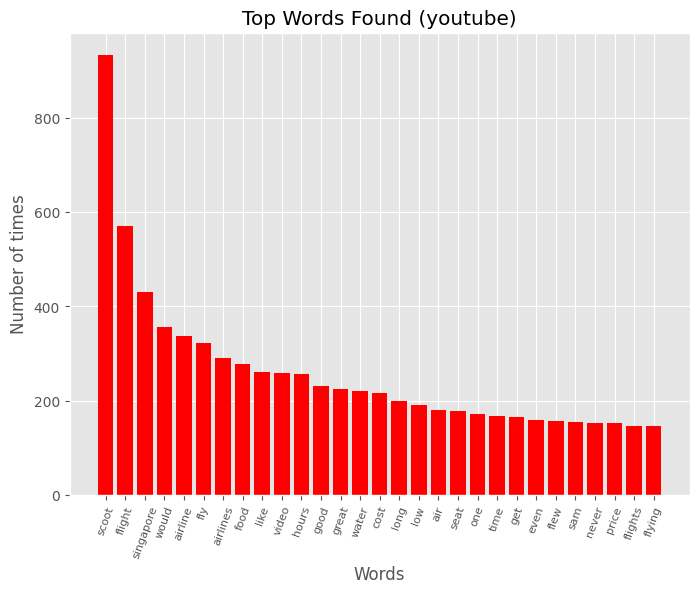


Reddit comments:
[(('scoot',), 18), (('singapore',), 16), (('flight',), 15), (('gt',), 15), (('one',), 13), (('flights',), 12), (('787',), 12), (('airline',), 11), (('vtl',), 11), (('london',), 11), (('2',), 10), (('like',), 9), (('3',), 8), (('take',), 7), (('barry',), 7), (('wheel',), 6), (('think',), 6), (('airlines',), 6), (('cost',), 6), (('flew',), 6), (('pretty',), 6), (('noise',), 6), (('difference',), 6), (('bangkok',), 6), (('seats',), 6), (('even',), 5), (('notice',), 5), (('got',), 5), (('would',), 5), (('carrier',), 5)]
Top Word: scoot
Top Word Count: 18
Number of e-grams found: 30


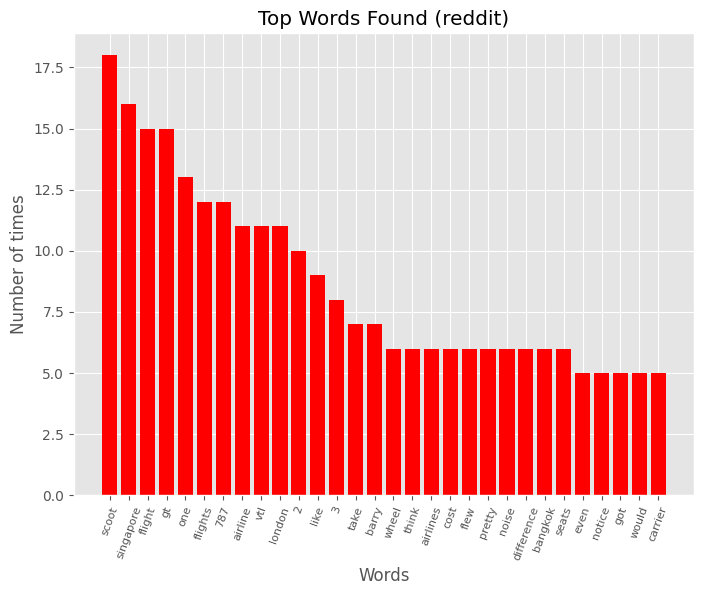


article:
[(('flight',), 17), (('scoot',), 15), (('boeing',), 11), (('dreamliner',), 11), (('boeing', '787'), 8), (('787',), 8), (('seat',), 8), (('cabin',), 8), (('service',), 7), (('boeing', '787', 'dreamliner'), 6), (('787', 'dreamliner'), 6), (('singapore',), 5), (('kuala',), 5), (('kuala', 'lumpur'), 5), (('lumpur',), 5), (('first',), 5), (('airlines',), 5), (('low',), 5), (('low', 'cost'), 5), (('cost',), 5), (('time',), 5), (('windows',), 5), (('also',), 4), (('one',), 4), (('long',), 4), (('could',), 4), (('seats',), 4), (('would',), 4), (('make',), 4), (('feel',), 4)]
Top Word: flight
Top Word Count: 17
Number of e-grams found: 30


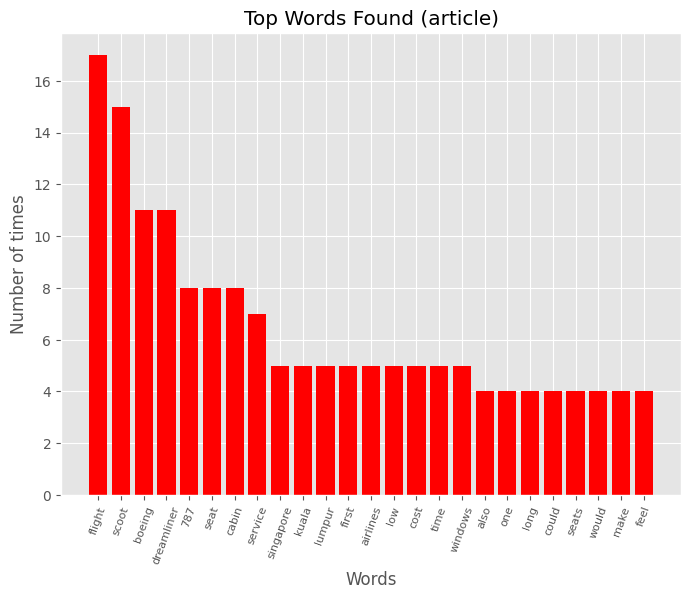


brochure:
[(('787',), 444), (('3',), 377), (('2023',), 374), (('5',), 333), (('model',), 319), (('2',), 313), (('model', '787'), 312), (('1',), 289), (('6',), 264), (('7',), 264), (('4',), 253), (('9',), 252), (('8',), 229), (('boeing',), 204), (('10',), 197), (('subject',), 190), (('february',), 188), (('d6',), 187), (('d6', '58333'), 187), (('58333',), 187), (('rev',), 187), (('february', '2023'), 187), (('ear',), 187), (('itar',), 187), (('copyright',), 187), (('copyright', '2023'), 187), (('copyright', '2023', 'boeing'), 187), (('2023', 'boeing'), 187), (('2023', 'boeing', 'rights'), 187), (('boeing', 'rights'), 187)]
Top Word: 787
Top Word Count: 444
Number of e-grams found: 30


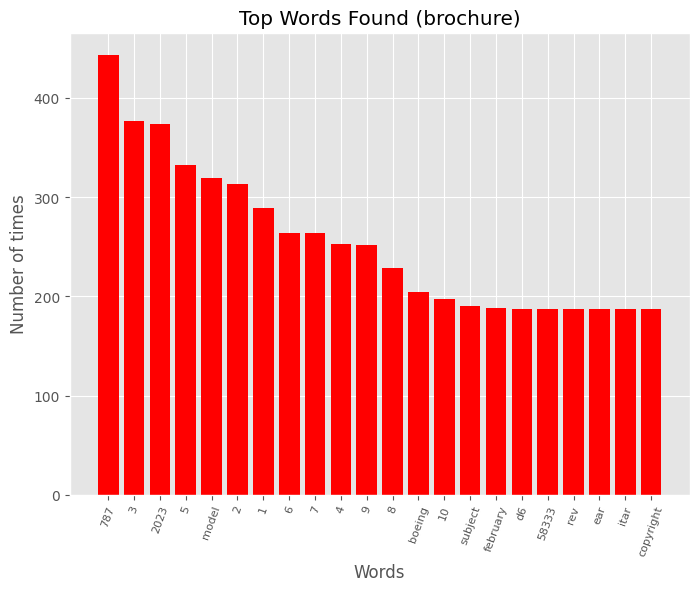


textbook:
[(('aircraft',), 1785), (('0',), 840), (('wing',), 678), (('design',), 652), (('engine',), 564), (('1',), 530), (('fig',), 431), (('e',), 427), (('mass',), 414), (('fuel',), 414), (('2',), 395), (('3',), 372), (('take',), 367), (('5',), 361), (('weight',), 347), (('fuselage',), 343), (('ratio',), 325), (('cost',), 317), (('thrust',), 312), (('10',), 308), (('cruise',), 307), (('drag',), 306), (('maximum',), 296), (('may',), 288), (('range',), 275), (('shown',), 268), (('flight',), 253), (('used',), 252), (('4',), 248), (('climb',), 246)]
Top Word: aircraft
Top Word Count: 1785
Number of e-grams found: 30


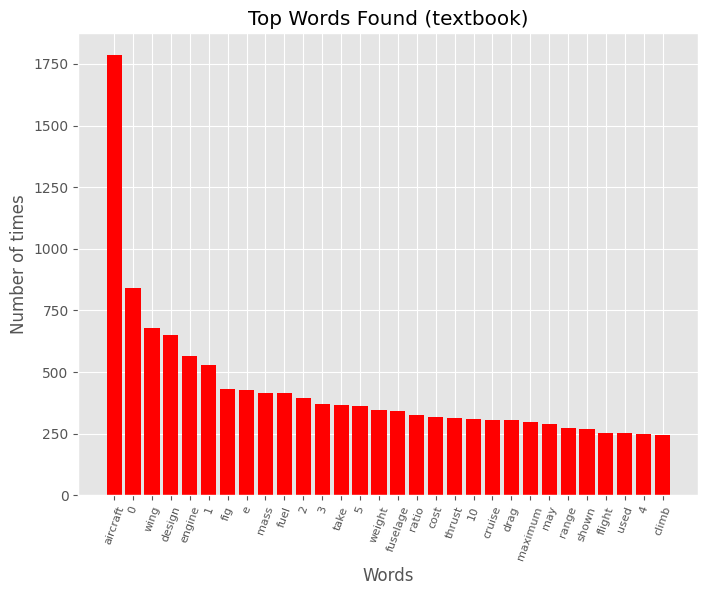

In [10]:
print("--- TOP WORDS SUMMARY ---")
print("Youtube comments:")
find_top_words(all_youtube_comments, "youtube")
print()
print("Reddit comments:")
find_top_words(all_reddit_comments, "reddit")
print()
print("article:")
find_top_words(article, "article")
print()
print("brochure:")
find_top_words(brochure, "brochure")
print()
print("textbook:")
find_top_words(textbook, "textbook")

## WordCloud Visualisation of Top Words

In [11]:
""" Generate WordCloud """
def generate_wordcloud(all_text, file):
    from wordcloud import WordCloud, STOPWORDS
    STOPWORDS.update(stopwords)

    wc = WordCloud(stopwords=STOPWORDS, background_color="white", colormap="Dark2", collocations=False,
                max_font_size=150, include_numbers=True, random_state=42, max_words=50)

    wc.generate(all_text)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("%s (%s)" % (search_terms, file), fontsize=10)
    plt.savefig("support/%s/%s/WordCloud.png" % (search_terms, file))
    plt.show()

--- WORD CLOUD SUMMARY ---
youtube comments:


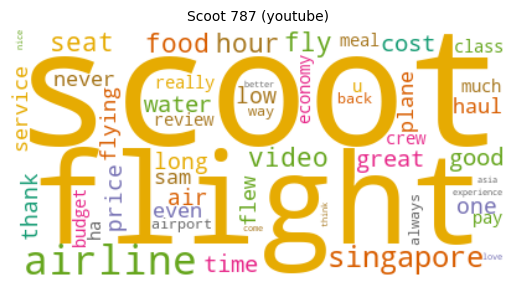


reddit comments:


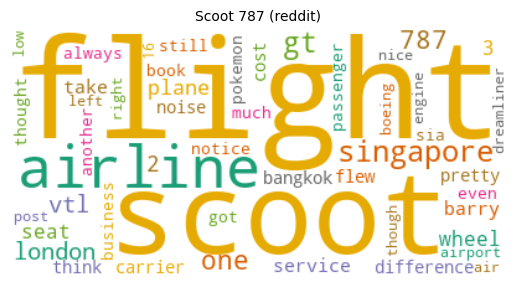


article:


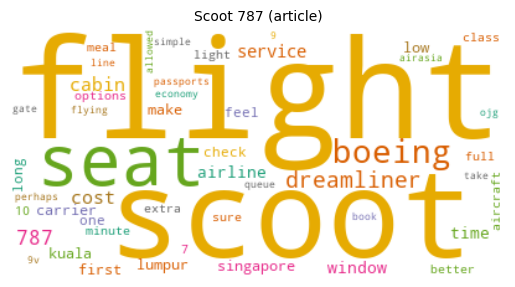


brochure:


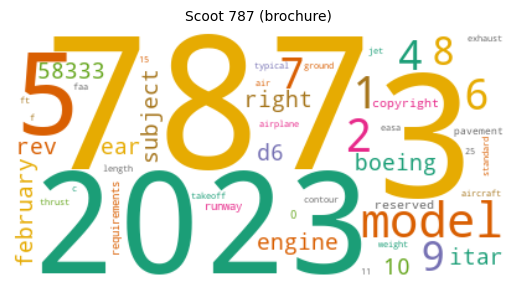


textbook:


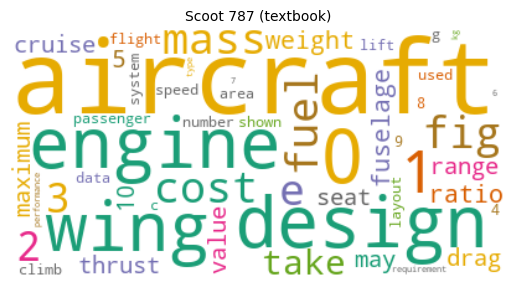

In [12]:
print("--- WORD CLOUD SUMMARY ---")
print("youtube comments:")
generate_wordcloud(all_youtube_comments, "youtube")
print()
print("reddit comments:")
generate_wordcloud(all_reddit_comments, "reddit")
print()
print("article:")
generate_wordcloud(article, "article")
print()
print("brochure:")
generate_wordcloud(brochure, "brochure")
print()
print("textbook:")
generate_wordcloud(textbook, "textbook")